In [ ]:
!pip install tensorflow numpy matplotlib seaborn scikit-learn tqdm datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve
from datasets import load_dataset

from tensorflow.keras.layers import (
    RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness
)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
@tf.keras.utils.register_keras_serializable()
class WarmUpExponentialDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, decay_steps, decay_rate, warmup_steps):
        super(WarmUpExponentialDecay, self).__init__()
        self.initial_lr = initial_lr
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        # Ensure all values are in float32
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        decay_steps = tf.cast(self.decay_steps, tf.float32)
        initial_lr = tf.cast(self.initial_lr, tf.float32)
        decay_rate = tf.cast(self.decay_rate, tf.float32)

        warmup_lr = initial_lr * (step / warmup_steps)
        decay_lr = initial_lr * tf.math.exp(-decay_rate * ((step - warmup_steps) / decay_steps))
        return tf.cond(step < warmup_steps, lambda: warmup_lr, lambda: decay_lr)

    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "decay_steps": self.decay_steps,
            "decay_rate": self.decay_rate,
            "warmup_steps": self.warmup_steps
        }

In [ ]:
model_path = '/content/drive/MyDrive/ML Project/New Folder/CustomCNN_8625.keras'
model = tf.keras.models.load_model(model_path, custom_objects={'WarmUpExponentialDecay': WarmUpExponentialDecay})

In [ ]:
# Load dataset
ds = load_dataset("JamieWithofs/Deepfake-and-real-images-4")
ds

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/622 [00:00<?, ?B/s]

train-00000-of-00006.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

train-00001-of-00006.parquet:   0%|          | 0.00/207M [00:00<?, ?B/s]

train-00002-of-00006.parquet:   0%|          | 0.00/287M [00:00<?, ?B/s]

train-00003-of-00006.parquet:   0%|          | 0.00/518M [00:00<?, ?B/s]

train-00004-of-00006.parquet:   0%|          | 0.00/519M [00:00<?, ?B/s]

train-00005-of-00006.parquet:   0%|          | 0.00/312M [00:00<?, ?B/s]

test-00000-of-00002.parquet:   0%|          | 0.00/366M [00:00<?, ?B/s]

test-00001-of-00002.parquet:   0%|          | 0.00/370M [00:00<?, ?B/s]

validation-00000-of-00002.parquet:   0%|          | 0.00/401M [00:00<?, ?B/s]

validation-00001-of-00002.parquet:   0%|          | 0.00/385M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/121159 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/35304 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/53184 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 121159
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 35304
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 53184
    })
})

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 512

In [ ]:
# Creating augmentation layers
flip_layer = RandomFlip("horizontal")
rotation_layer = RandomRotation(0.1)
zoom_layer = RandomZoom(0.1)
contrast_layer = RandomContrast(0.1)
brightness_layer = RandomBrightness(0.2)

In [ ]:
def to_tf_dataset(hf_dataset):
    return hf_dataset.to_tf_dataset(
        columns=['image', 'label'],
        shuffle=True if hf_dataset == ds['train'] else False,
        batch_size=BATCH_SIZE,
    ).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
def preprocess(example):
    image = tf.image.resize(example['image'], [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image, example['label']

def to_tf_dataset(hf_dataset):
    return hf_dataset.to_tf_dataset(
        columns=['image', 'label'],
        shuffle=False,
        batch_size=BATCH_SIZE,
    ).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Convert Hugging Face dataset to TensorFlow dataset
test_ds = to_tf_dataset(ds['test']).prefetch(tf.data.AUTOTUNE)

In [ ]:
y_true = []
y_pred_probs = []

for batch_images, batch_labels in test_ds:
    y_true.extend(batch_labels.numpy())
    y_pred_probs.extend(model.predict(batch_images, verbose=0).flatten())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_classes = (y_pred_probs > 0.5).astype(int)  # Convert to binary predictions

# Compute test accuracy and AUC
test_acc = np.mean(y_pred_classes == y_true)
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

print("\nTest Evaluation Results:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {roc_auc:.4f}")


Test Evaluation Results:
Test Accuracy: 0.8625
Test AUC: 0.9327


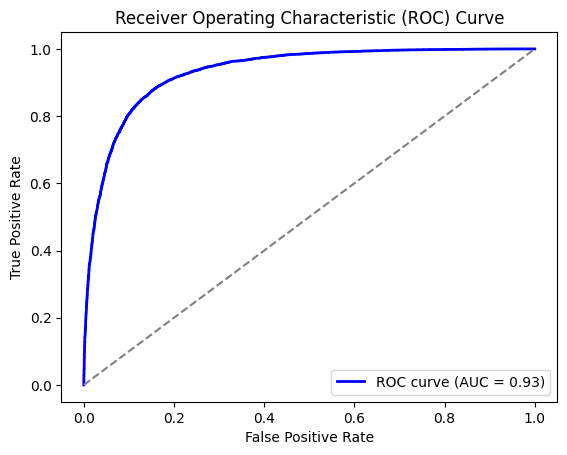

In [ ]:
# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

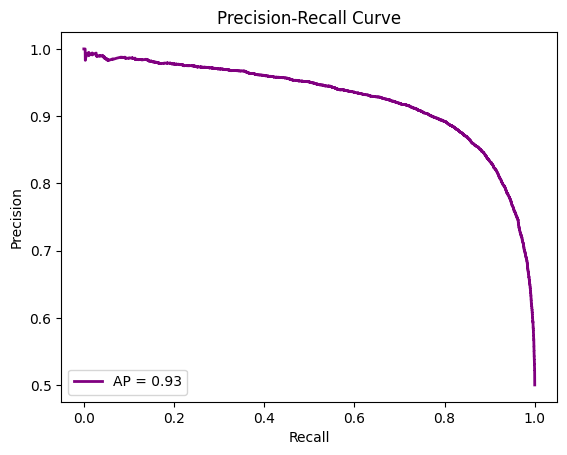

In [ ]:
# Compute & plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
avg_precision = average_precision_score(y_true, y_pred_probs)

plt.figure()
plt.plot(recall, precision, color="purple", lw=2, label=f"AP = {avg_precision:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

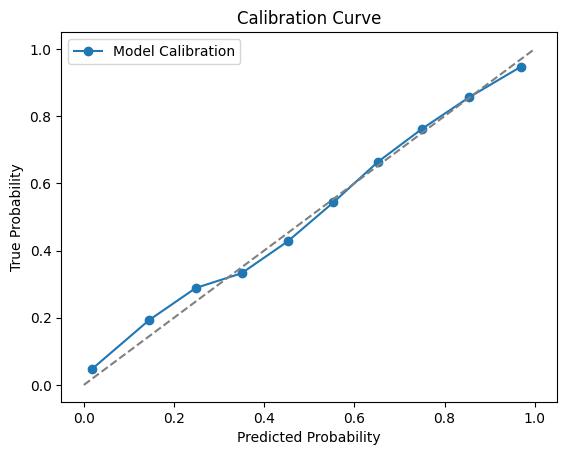

In [ ]:
# Compute & plot Calibration Curve
prob_true, prob_pred = calibration_curve(y_true, y_pred_probs, n_bins=10)
plt.figure()
plt.plot(prob_pred, prob_true, marker="o", label="Model Calibration")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.legend()
plt.show()

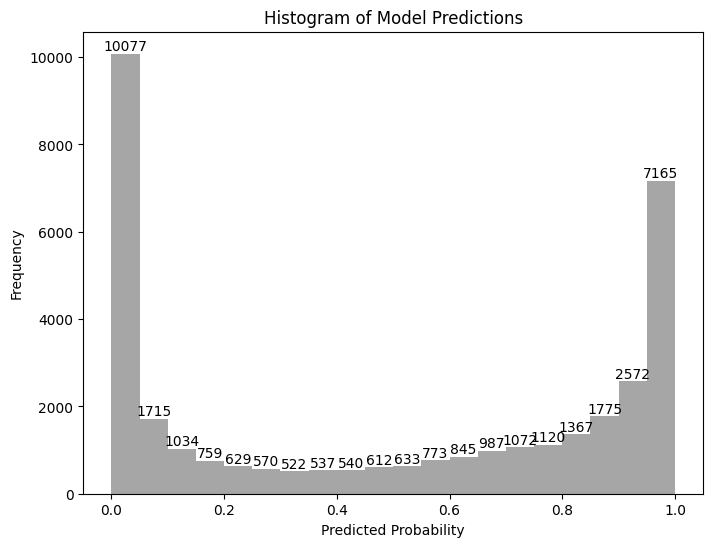

In [ ]:
# Continuous Histogram of Prediction Probabilities
plt.figure(figsize=(8, 6))
counts, bins, patches = plt.hist(y_pred_probs, bins=20, color='gray', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Model Predictions')

# Annotate each bin with its count
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count, f'{int(count)}',
             ha='center', va='bottom', fontsize=10)

plt.show()


Threshold: 0.3
Test Accuracy: 0.8477


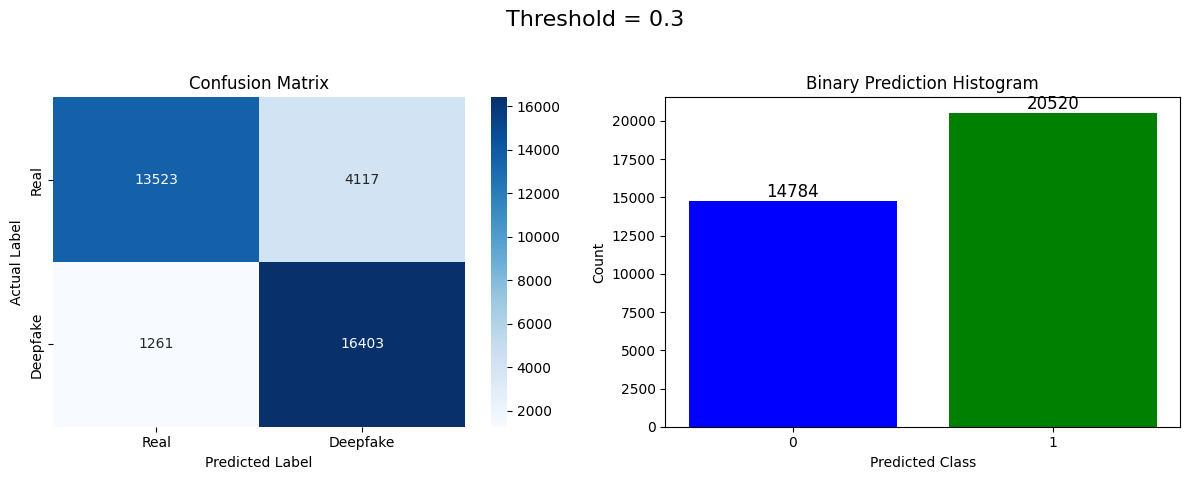


Threshold: 0.4
Test Accuracy: 0.8577


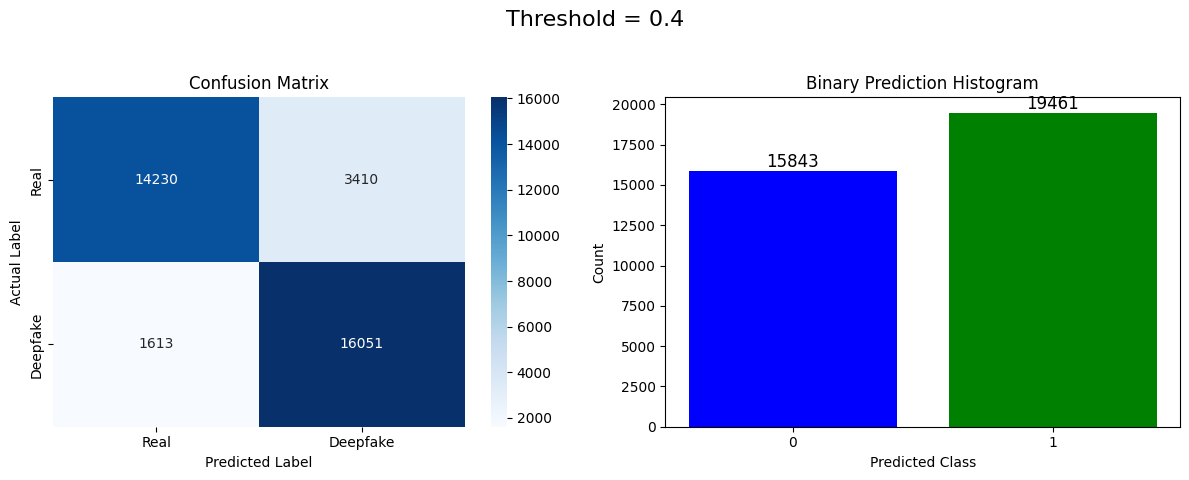


Threshold: 0.5
Test Accuracy: 0.8625


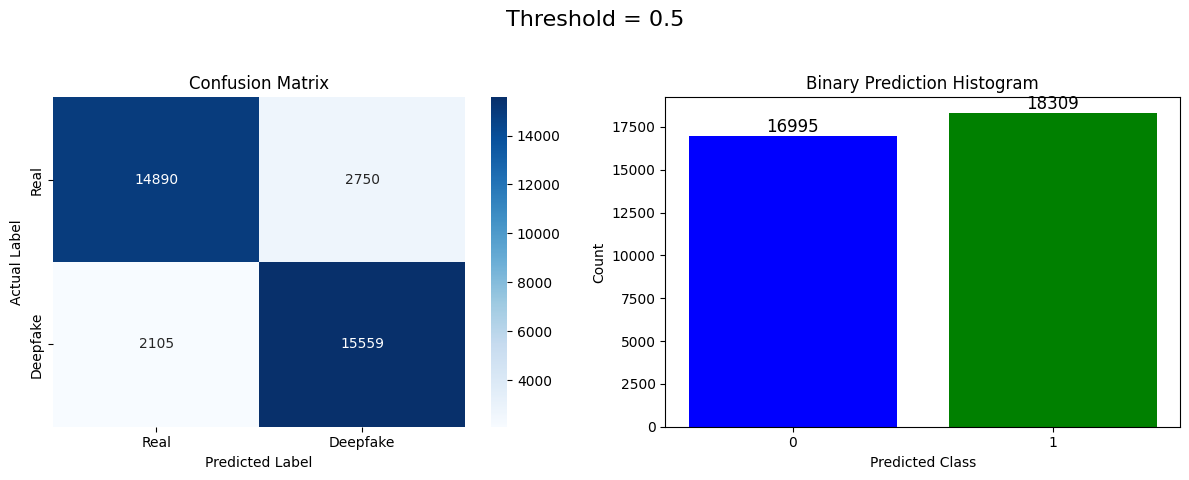


Threshold: 0.6
Test Accuracy: 0.8590


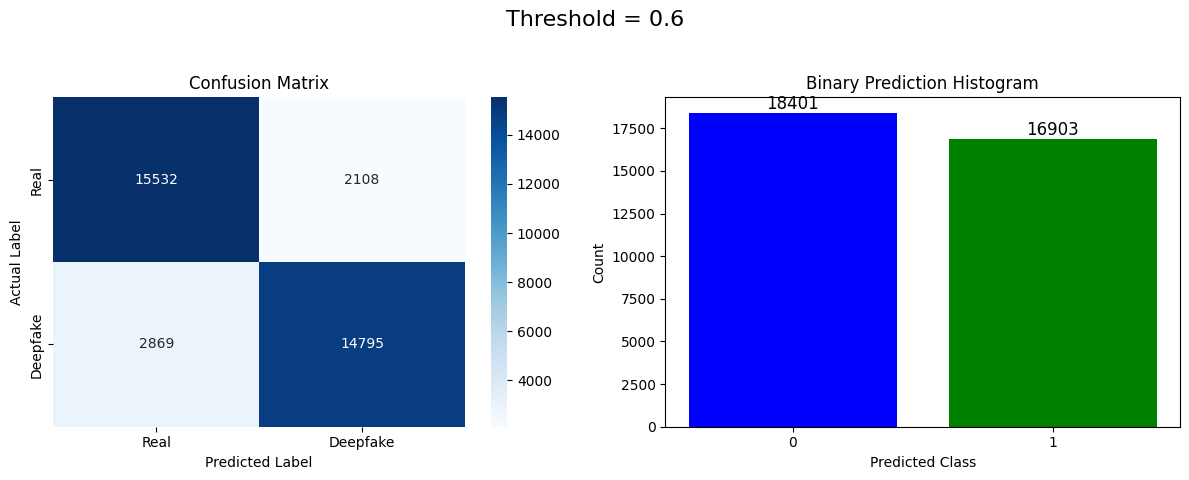


Threshold: 0.7
Test Accuracy: 0.8421


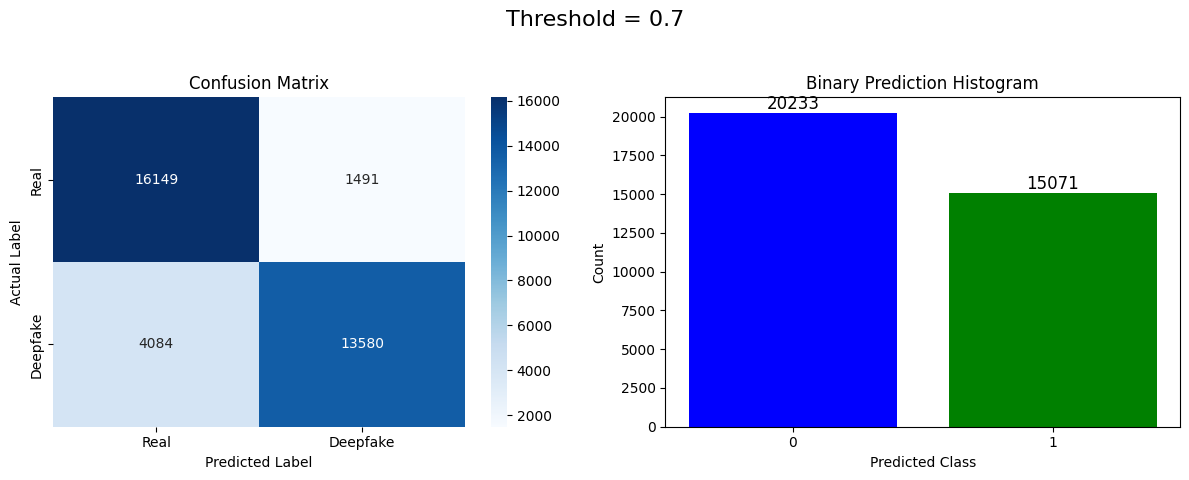

In [ ]:
# Threshold-based analysis
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for thresh in thresholds:
    y_pred_classes = (y_pred_probs >= thresh).astype(int)
    test_accuracy = (y_pred_classes == y_true).mean()

    print(f"\nThreshold: {thresh}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Create figure for confusion matrix and bar chart
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"Threshold = {thresh}", fontsize=16)

    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Deepfake'], yticklabels=['Real', 'Deepfake'], ax=axs[0])
    axs[0].set_xlabel('Predicted Label')
    axs[0].set_ylabel('Actual Label')
    axs[0].set_title('Confusion Matrix')

    # Bar Chart of Binary Predictions
    unique, counts = np.unique(y_pred_classes, return_counts=True)
    axs[1].bar(unique, counts, color=['blue', 'green'])
    axs[1].set_xticks([0, 1])
    axs[1].set_xlabel('Predicted Class')
    axs[1].set_ylabel('Count')
    axs[1].set_title('Binary Prediction Histogram')
    for i, count in zip(unique, counts):
        axs[1].text(i, count + 1, str(count), ha='center', va='bottom', fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=["Real", "Fake"]))


Classification Report:
              precision    recall  f1-score   support

        Real       0.88      0.84      0.86     17640
        Fake       0.85      0.88      0.87     17664

    accuracy                           0.86     35304
   macro avg       0.86      0.86      0.86     35304
weighted avg       0.86      0.86      0.86     35304

